In [22]:
import sys
import warnings
import numpy as np

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from jupyterthemes import jtplot
jtplot.style()

from scipy import ndimage as ndi
from skimage import feature
from IPython.display import display

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Load path to the libs folder. 
path_libs = '/Users/mochen/Desktop/Insight/FingerSecure/src'
path_libs_ext = '/Users/mochen/Desktop/Insight/FingerSecure/src_ext'
sys.path.insert(0, path_libs)
sys.path.insert(1, path_libs_ext)

from libs.enhancing import *
from libs.basics import *
from libs.processing import *
from libs.minutiae import *

import minutiae_angles as mAngle
import minutiae_mtuples as mMtuple
import minutiae_matching as mMatch
import create_database as createDB

# Minutiae 
from scipy.spatial import distance
from itertools import combinations
import pickle

import pin_decryption
import functions

np.set_printoptions(edgeitems=800)
np.core.arrayprint._line_width = 800

pd.options.display.max_columns = None
pd.options.display.max_rows = None

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


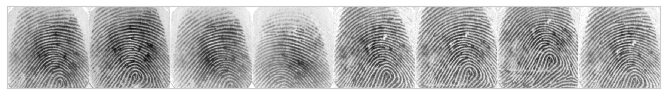

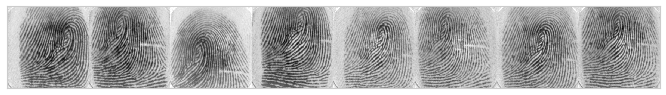

In [2]:
display_dataset('A', size=1.5, users=2)

### Purpose: check if a given fingerprint image matches any of the owners'


### 1. Enrollment

\
To create database with altered minutiae info.


In [3]:
# 1. Enrollment: 
# In total, 9 owners, each with 8 fingerprint images (from the same finger).

pins_all = [1325, 2562, 3390, 4342, 5190, 6374, 7823, 8518, 7893]
owners_database = createDB.createOwnersDatabase(max_owner=9, max_case=8, PINs=pins_all)
owners_database.create_minutiae_datatable()

Processing Owner 1's data... 
Processing Owner 2's data... 
Processing Owner 3's data... 
Processing Owner 4's data... 
Processing Owner 5's data... 
Processing Owner 6's data... 
Processing Owner 7's data... 
Processing Owner 8's data... 
Processing Owner 9's data... 


In [4]:
# save owners' database in binary format using pickle
# note:
#     minutiae_data_full.pkl - full database as reference (not needed in productization)
#     minutiae_data_final.pkl - final database

owners_database.save_datatable('minutiae_data_full.pkl', 'minutiae_data_final.pkl')

### 2. Identification 
\
    2.1. load database \
    2.2. user provides a fingerprint image and PIN \
    2.3. feature extraction of input image \
    2.4. recover altered minutiae in the database with user PIN - recover coords(x,y), angle \
    2.5. calculate all m-tuples and all angles using recovered coords \
    2.6. decide if user has access
    

\
Below shows three cases:

Case 1. owner3 with correct PIN. \
Case 2. owner3 with incorrect PIN. \
Case 3. an unknown user. 

#### Case 1. owner3 with correct PIN

In [5]:
# 2.1. load database
with open('minutiae_data_final.pkl', 'rb') as f:
    datatable = pickle.load(f)

In [6]:
# display final database with altered minutiae info
# x_alt, y_alt: altered minutiae coordinates
# angleType: end (ending points), bifurcation (bifurcation points)

datatable.head(3)

,Owner,Case,x_alt,y_alt,angleType,angle_alt,zone
0,1,1,82,252,end,120.000000,6
1,1,1,90,171,end,-170.537678,5
2,1,1,94,199,end,9.462322,5


In [7]:
# 2.2. user provide fingerprint image and user PIN
correct_pin_owner3 = 3390
user_pin = correct_pin_owner3
img_path_usr = '../data/Fingerprints - Set A/103_2.tif' 


INFO: Plotting terminations' coordinates in red
INFO: Plotting bifurcations' coordinates in cyan


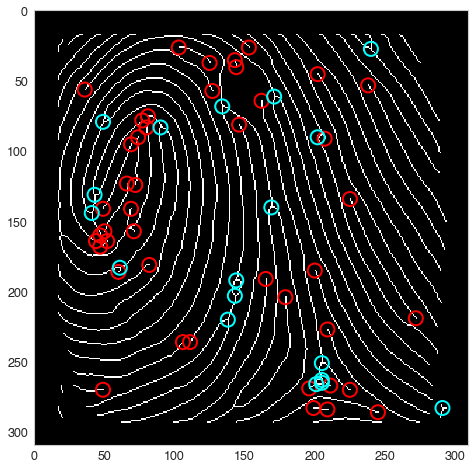

In [8]:
# 2.3. feature extraction of input image
(m_tuple_usr, minutiae_angle_usr) = functions.process_one_user(img_path_usr, plot=True)

In [9]:
# 2.4. recover altered minutiae in the database
datatable_rc = pin_decryption.decryption(user_pin, datatable)

# 2.5. calculate all m-tuples and all angles using recovered database
dict_m_tuples_all, dict_angles_all = functions.extract_features(datatable_rc, max_owner=9, max_case=8)

# 2.6. decide if user can access
mMatch.minutiae_matching(dict_m_tuples_all, dict_angles_all, m_tuple_usr, minutiae_angle_usr)

The person and owner 1 have [1, 1, 1, 0, 0, 0, 0, 0] in common.
The person and owner 2 have [0, 0, 0, 0, 0, 0, 0, 0] in common.
The person and owner 3 have [3, 62, 0, 6, 3, 4, 0, 0] in common.
The person and owner 4 have [0, 0, 0, 0, 0, 0, 0, 1] in common.
The person and owner 5 have [0, 0, 0, 0, 0, 1, 0, 0] in common.
The person and owner 6 have [0, 0, 0, 0, 0, 0, 1, 0] in common.
The person and owner 7 have [0, 0, 0, 0, 1, 1, 0, 0] in common.
The person and owner 8 have [0, 1, 1, 0, 0, 1, 0, 1] in common.
The person and owner 9 have [0, 0, 0, 1, 1, 1, 0, 0] in common.


'Identied - owner 3!'

#### Case 2. owner3 with incorrect PIN

In [23]:
# 2.1. user provide fingerprint image and user PIN
user_pin = 1234
img_path_usr = '../data/Fingerprints - Set A/103_2.tif' 

# 2.2. load database
with open('minutiae_data_full.pkl', 'rb') as f:
    datatable = pickle.load(f)

# 2.3. recover altered minutiae in the database
datatable_rc = pin_decryption.decryption(user_pin, datatable)

# 2.4. calculate all m-tuples and all angles using recovered database
dict_m_tuples_all, dict_angles_all = functions.extract_features(datatable_rc, max_owner=9, max_case=8)

# 2.5. feature extraction of input image
(m_tuple_usr, minutiae_angle_usr) = functions.process_one_user(img_path_usr)

# 2.6. decide if user can access
mMatch.minutiae_matching(dict_m_tuples_all, dict_angles_all, m_tuple_usr, minutiae_angle_usr)

The person and owner 1 have [0, 0, 0, 0, 0, 0, 0, 0] in common.
The person and owner 2 have [0, 0, 0, 1, 0, 0, 0, 0] in common.
The person and owner 3 have [0, 0, 0, 2, 0, 0, 0, 0] in common.
The person and owner 4 have [0, 0, 1, 0, 0, 0, 1, 0] in common.
The person and owner 5 have [0, 0, 0, 1, 0, 0, 0, 0] in common.
The person and owner 6 have [0, 0, 0, 0, 0, 0, 0, 0] in common.
The person and owner 7 have [0, 0, 0, 0, 0, 0, 0, 0] in common.
The person and owner 8 have [0, 0, 1, 0, 0, 0, 0, 1] in common.
The person and owner 9 have [0, 0, 0, 2, 0, 0, 0, 1] in common.


'Not Identified'

#### Case 3. an unknown user

In [11]:
# 2.1. user provide fingerprint image and user PIN
user_pin = 1234
img_path_usr = '../data/Fingerprints - Set A/110_2.tif' 

# 2.2. load database
with open('minutiae_data_full.pkl', 'rb') as f:
    datatable = pickle.load(f)

# 2.3. recover altered minutiae in the database
datatable_rc = pin_decryption.decryption(user_pin, datatable)

# 2.4. calculate all m-tuples and all angles using recovered database
dict_m_tuples_all, dict_angles_all = functions.extract_features(datatable_rc, max_owner=9, max_case=8)

# 2.5. feature extraction of input image
(m_tuple_usr, minutiae_angle_usr) = functions.process_one_user(img_path_usr)

# 2.6. decide if user can access
mMatch.minutiae_matching(dict_m_tuples_all, dict_angles_all, m_tuple_usr, minutiae_angle_usr, False)

'Not Identified'

### More Testing and Analysis

In [32]:
# Check if the system can identify all users
# The first 9 persons: owners
# The last 1 person: intrudor

pins_all = [1325, 2562, 3390, 4342, 5190, 6374, 7823, 8518, 7893, 111]

with open('minutiae_data_full.pkl', 'rb') as f:
    datatable = pickle.load(f)

for i in range(len(pins_all)):
    print("--------------")
    user = i + 1
    print("Input - owner %d" %user)

    # 2.1. user provide fingerprint image and user PIN
    user_pin = pins_all[i]
    img_path_usr = '../data/Fingerprints - Set A/%d_4.tif' %(100+user)

    # 2.2. load database
    with open('minutiae_data_full.pkl', 'rb') as f:
        datatable = pickle.load(f)

    # 2.3. recover altered minutiae in the database
    datatable_rc = pin_decryption.decryption(user_pin, datatable)

    # 2.4. calculate all m-tuples and all angles using recovered database
    dict_m_tuples_all, dict_angles_all = functions.extract_features(datatable_rc, max_owner=9, max_case=8)

    # 2.5. feature extraction of input image
    (m_tuple_usr, minutiae_angle_usr) = functions.process_one_user(img_path_usr)

    # 2.6. decide if user can access
    result = mMatch.minutiae_matching(dict_m_tuples_all, dict_angles_all, m_tuple_usr, minutiae_angle_usr, False)
    
    print(result)

--------------
Input - owner 1
Identied - owner 1!
--------------
Input - owner 2
Identied - owner 2!
--------------
Input - owner 3
Identied - owner 3!
--------------
Input - owner 4
Identied - owner 4!
--------------
Input - owner 5
Identied - owner 5!
--------------
Input - owner 6
Identied - owner 6!
--------------
Input - owner 7
Identied - owner 7!
--------------
Input - owner 8
Identied - owner 8!
--------------
Input - owner 9
Identied - owner 9!
--------------
Input - owner 10
Not Identified
